## Table of Contents
1. [Import libraries and load csv file](#1.-Import-libraries-and-load-csv-file)
1. [Explore data](#2.-Explore-data)
1. [Data cleaning](#3.-Data-cleaning)
1. [Analyse TOP regions](#4.-Discover-regions)
1. [US totals analyse](#5.-US-totals-analyse)  
   5.1. [Total volume and average price trends in US](#5.1.-Total-volume-and-average-price-trends-in-US)  
   5.2. [Number of avocado sold timeline distribution by month](#5.2.-Number-of-avocado-sold-timeline-distribution-by-month)  
   5.3. [Average price analyse](#5.3.-Average-price-analyse)  
   5.4. [Forecast](#5.4.-Forecast)  
   5.5. [Avocado by size and type analyse](#5.5.Avocado-by-size-and-type-analyse)  

## 1. Import libraries and load csv file


In [271]:
import pandas as pd
import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from datetime import date

from fbprophet import Prophet

In [272]:
# First of all open file and rename columns for the convenient format (without spaces and capital letters)

av_df = pd.read_csv('avocado.csv', parse_dates=['Date'], index_col=0)
av_df = av_df.rename(columns = {'Date' : 'date', 
                                'AveragePrice' : 'avg_price', 
                                'Total Volume' : 'total_sold', 
                                '4046' : 'small_av', 
                                '4225' : 'large_av', 
                                '4770' : 'xlarge_av', 
                                'Total Bags' : 'total_bags', 
                                'Small Bags' : 'small_bags', 
                                'Large Bags':'large_bags', 
                                'XLarge Bags' : 'xlarge_bags'})
av_df.tail(2)

,date,avg_price,total_sold,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags,type,year,region
10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
11,2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


## 2. Explore data

In [273]:
# Check if there is any missing value
av_df.isna().any()

# There is no missing values

date           False
avg_price      False
total_sold     False
small_av       False
large_av       False
xlarge_av      False
total_bags     False
small_bags     False
large_bags     False
xlarge_bags    False
type           False
year           False
region         False
dtype: bool

In [274]:
av_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         18249 non-null  datetime64[ns]
 1   avg_price    18249 non-null  float64       
 2   total_sold   18249 non-null  float64       
 3   small_av     18249 non-null  float64       
 4   large_av     18249 non-null  float64       
 5   xlarge_av    18249 non-null  float64       
 6   total_bags   18249 non-null  float64       
 7   small_bags   18249 non-null  float64       
 8   large_bags   18249 non-null  float64       
 9   xlarge_bags  18249 non-null  float64       
 10  type         18249 non-null  object        
 11  year         18249 non-null  int64         
 12  region       18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.9+ MB


## 3. Data cleaning

### 3.1. Duplicates checking

In [275]:
# Check if there are duplicates
columns = ['date', 'total_sold', 'region']
duplicates = av_df.duplicated(subset = columns, keep = False)
assert av_df[duplicates]['date'].count() == 0

# As we can see there are no duplicates

### 3.2. Check and change data types

In [276]:
# If there is a date greater than today's date we will assign it to today's date
print('Date min: ', av_df['date'].min(), '/nDate max: ', av_df['date'].max())

Date min:  2015-01-04 00:00:00 /nDate max:  2018-03-25 00:00:00


In [277]:
#change avocado type to categorical variable
av_df['type'] = av_df['type'].astype('category')
av_df['type'].dtype

CategoricalDtype(categories=['conventional', 'organic'], ordered=False)

### 3.3. Check for the consistency

In [278]:
# check for consistency
total_bags_equ = av_df.total_bags == (av_df.small_bags+av_df.large_bags+av_df.xlarge_bags)
inconsistent_bags = av_df[~total_bags_equ]
consistent_bags = av_df[total_bags_equ]

total_sold_equ = av_df['total_sold'] == av_df['total_bags'] + av_df['small_av'] + av_df['large_av'] + av_df['xlarge_av']
inconsistent_volume = av_df[~total_sold_equ]
consistent_volume = av_df[total_sold_equ]

print(
    'consistent bags: ', consistent_bags.shape[0], 
    '\ninconsistent bags: ', inconsistent_bags.shape[0], 
    '\n\nconsistent volume: ', consistent_volume.shape[0], 
    '\ninconsistent volume:', inconsistent_volume.shape[0], 
    '\n\ntotal volume: ', av_df['total_sold'].sum())

consistent bags:  14213 
inconsistent bags:  4036 

consistent volume:  12255 
inconsistent volume: 5994 

total volume:  15523402593.400002


In [279]:
# Number of avocado sold couldn't be a float. Due to rounding operation we see a lot of values with inconsistency. Therefore I decided to convert values to integer (but before, I'll round them to avoid big influence).

float_columns = ['total_sold', 'small_av', 'large_av', 'xlarge_av', 
                 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags']
av_df[float_columns] = av_df[float_columns].round(0).astype('int')

# Let's check 'total volume value' after rounding:
print('Total volume: ', av_df['total_sold'].sum(), '\n\nValues types:\n', av_df.dtypes)

Total volume:  15523402577 

Values types:
 date           datetime64[ns]
avg_price             float64
total_sold              int64
small_av                int64
large_av                int64
xlarge_av               int64
total_bags              int64
small_bags              int64
large_bags              int64
xlarge_bags             int64
type                 category
year                    int64
region                 object
dtype: object


In [280]:
# For further analyses the most important columns are totals. Therefore I don't want to influence on them while eliminating inconsistence. So, I will recalculate amounts of small avocados sold and small bags sold.

av_df['small_bags'] = av_df['total_bags'] - av_df['large_bags'] - av_df['xlarge_bags']
av_df['small_av'] = av_df['total_sold'] - av_df['large_av'] - av_df['xlarge_av'] - av_df['total_bags']

In [281]:
# Let's check inconsistency once more
total_bags_equ = av_df.total_bags == (av_df.small_bags+av_df.large_bags+av_df.xlarge_bags)
inconsistent_bags = av_df[~total_bags_equ]

total_sold_equ = av_df['total_sold'] == av_df['total_bags'] + av_df['small_av'] + av_df['large_av'] + av_df['xlarge_av']
inconsistent_volume = av_df[~total_sold_equ]
print('inconsistent bags: ', inconsistent_bags.shape[0], 
      '\ninconsistent volume:', inconsistent_volume.shape[0],
      '\ntotal volume change: ', av_df.total_sold.sum() - total_sold_equ.sum())

inconsistent bags:  0 
inconsistent volume: 0 
total volume change:  15523384328


### 3.4. Create new columns and ordering them

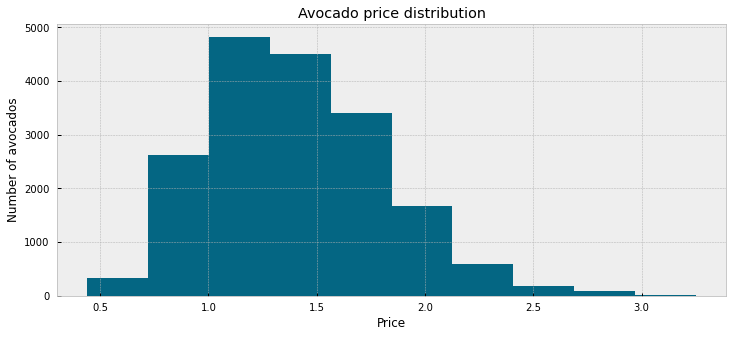

In [282]:
# Analysing price distribution
fig, ax = plt.subplots(figsize=(12,5))

plt.hist(av_df.avg_price, color = '#046683')

plt.xlabel('Price')
plt.ylabel('Number of avocados')
plt.title('Avocado price distribution')
plt.show()

In [283]:
# Let's group regions by average price categories
# According to the histogram, we can devide our data by 3 categories

category_ranges = [0, 1, 2, np.inf]
category_names = ['Low', 'Medium', 'High']

av_df['price_category'] = pd.cut(av_df.avg_price, bins = category_ranges, labels = category_names)
av_df.head(3)

,date,avg_price,total_sold,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,price_category
0,2015-12-27,1.33,64237,1037,54455,48,8697,8604,93,0,conventional,2015,Albany,Medium
1,2015-12-20,1.35,54877,674,44639,58,9506,9409,97,0,conventional,2015,Albany,Medium
2,2015-12-13,0.93,118220,795,109150,130,8145,8042,103,0,conventional,2015,Albany,Low


In [284]:
# Adding month column

av_df['month'] = pd.DatetimeIndex(av_df['date']).month_name()
av_df.head()

,date,avg_price,total_sold,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,price_category,month
0,2015-12-27,1.33,64237,1037,54455,48,8697,8604,93,0,conventional,2015,Albany,Medium,December
1,2015-12-20,1.35,54877,674,44639,58,9506,9409,97,0,conventional,2015,Albany,Medium,December
2,2015-12-13,0.93,118220,795,109150,130,8145,8042,103,0,conventional,2015,Albany,Low,December
3,2015-12-06,1.08,78992,1132,71976,73,5811,5677,134,0,conventional,2015,Albany,Medium,December
4,2015-11-29,1.28,51040,942,43838,76,6184,5986,198,0,conventional,2015,Albany,Medium,November


In [285]:
# Ordering columns
# At first we could get list of columns names
av_df.columns

Index(['date', 'avg_price', 'total_sold', 'small_av', 'large_av', 'xlarge_av',
       'total_bags', 'small_bags', 'large_bags', 'xlarge_bags', 'type', 'year',
       'region', 'price_category', 'month'],
      dtype='object')

In [286]:
# Ordering columns
col_list = ['date', 'year', 'month', 'region', 'type', 'avg_price', 'price_category', 'total_sold', 'small_av', 'large_av', 'xlarge_av', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags']
av_df = av_df.reindex(columns=col_list)
av_df.head(2)

,date,year,month,region,type,avg_price,price_category,total_sold,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags
0,2015-12-27,2015,December,Albany,conventional,1.33,Medium,64237,1037,54455,48,8697,8604,93,0
1,2015-12-20,2015,December,Albany,conventional,1.35,Medium,54877,674,44639,58,9506,9409,97,0


In [287]:
# Save cleaned file for further processing
av_df.to_csv('avocado_cleaned.csv', index = False)

## 4. Discover regions


In [288]:
av_df = pd.read_csv('avocado_cleaned.csv')

regions = av_df.groupby(av_df.region)
print('Total number of regions: ', len(regions))
print('________________________________')
for name, group in regions:
    print(name, ':', len(group))

Total number of regions:  54
________________________________
Albany : 338
Atlanta : 338
BaltimoreWashington : 338
Boise : 338
Boston : 338
BuffaloRochester : 338
California : 338
Charlotte : 338
Chicago : 338
CincinnatiDayton : 338
Columbus : 338
DallasFtWorth : 338
Denver : 338
Detroit : 338
GrandRapids : 338
GreatLakes : 338
HarrisburgScranton : 338
HartfordSpringfield : 338
Houston : 338
Indianapolis : 338
Jacksonville : 338
LasVegas : 338
LosAngeles : 338
Louisville : 338
MiamiFtLauderdale : 338
Midsouth : 338
Nashville : 338
NewOrleansMobile : 338
NewYork : 338
Northeast : 338
NorthernNewEngland : 338
Orlando : 338
Philadelphia : 338
PhoenixTucson : 338
Pittsburgh : 338
Plains : 338
Portland : 338
RaleighGreensboro : 338
RichmondNorfolk : 338
Roanoke : 338
Sacramento : 338
SanDiego : 338
SanFrancisco : 338
Seattle : 338
SouthCarolina : 338
SouthCentral : 338
Southeast : 338
Spokane : 338
StLouis : 338
Syracuse : 338
Tampa : 338
TotalUS : 338
West : 338
WestTexNewMexico : 335


In [289]:
av_df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

In [290]:
# region = TotalUS is not a region description but summary information. Therefore, I'll filter these rows
av_df_nototals = av_df[av_df['region'] != 'TotalUS']
av_df_nototals['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'West', 'WestTexNewMexico'], dtype=object)

### 4.1. Analyse TOP 10 regions by total sold

In [291]:
# Analyse regions
organic = av_df_nototals[av_df_nototals.type == 'organic'][['date','region', 'total_sold', 'avg_price']]
conventional = av_df_nototals[av_df_nototals.type == 'conventional'][['date','region', 'total_sold', 'avg_price']]

# Show 10 TOP regions by solding organic avocados
org_reg = organic.groupby('region').agg({'total_sold':'sum', 'avg_price':'mean'}).sort_values(by = 'total_sold', ascending=False).nlargest(10, columns = 'total_sold').rename(columns = {'total_sold':'org_sold', 'avg_price':'org_avg_price'})

conv_reg = conventional.groupby('region').agg({'total_sold':'sum', 'avg_price':'mean'}).sort_values(by = 'total_sold', ascending=False).nlargest(10, columns = 'total_sold').rename(columns = {'total_sold':'conv_sold', 'avg_price':'conv_avg_price'})

# Analyse TOP 10 regions by total sold
largest_reg = pd.concat([conv_reg, org_reg], axis = 1).sort_values(by = 'conv_sold', ascending = False)
largest_reg

,conv_sold,conv_avg_price,org_sold,org_avg_price
West,1049360586,0.985089,37418564,1.559349
California,1003596839,1.105444,25384814,1.685207
SouthCentral,993161156,0.869408,18118468,1.333077
Northeast,689054816,1.344438,24226094,1.859408
Southeast,605198759,1.163018,10039658,1.633018
GreatLakes,567567855,1.181893,22074680,1.495207
LosAngeles,494510273,0.976450,13386284,1.455562
Midsouth,490368909,1.207160,17980438,1.602367
Plains,302912658,1.165503,8275868,1.707515
NewYork,231743558,1.402130,8990571,2.053018


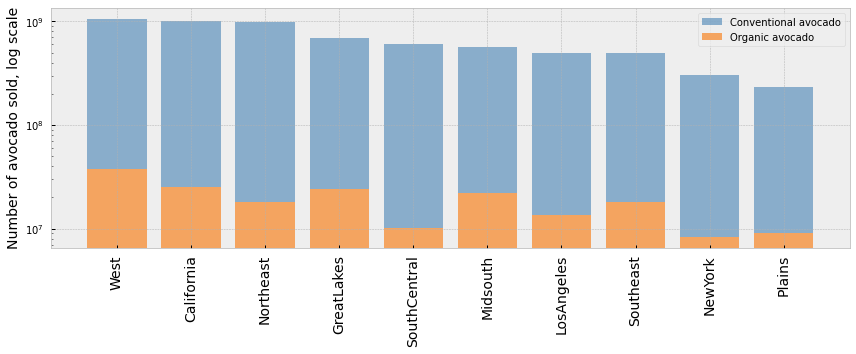

In [292]:
# Chart of avocado sold by region
plt.style.use('bmh')

fig, ax = plt.subplots(figsize=(12,5))

ax.bar(largest_reg.index, largest_reg.conv_sold, color = 'steelblue', alpha = 0.6, log = True, label = 'Conventional avocado')
ax.bar(largest_reg.index, largest_reg.org_sold, color = 'sandybrown', log = True, label = 'Organic avocado')

ax.set_xticklabels(org_reg.index, rotation=90, fontsize = 14)
ax.set_ylabel('Number of avocado sold, log scale', fontsize = 14)

plt.legend()

plt.tight_layout()
plt.savefig(r'files/avocado_sold_top_reg.jpg')
plt.show()

### 4.2. Analyse average price for avocado in TOP regions

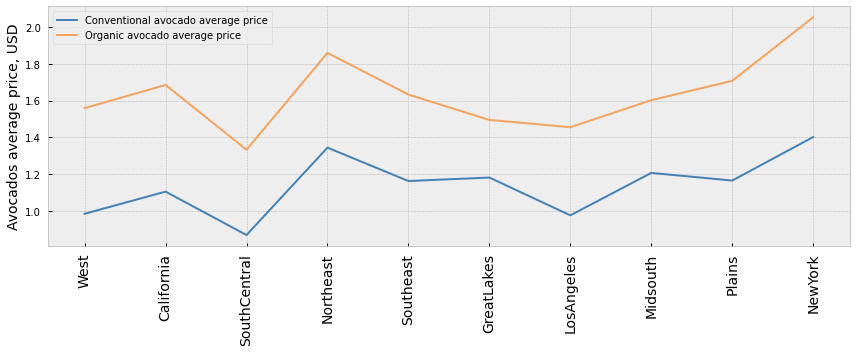

In [293]:
# Chart of organic and conventional avocado total sold by region
fig, ax = plt.subplots(figsize = (12, 5))

ax.plot(largest_reg.index, largest_reg.conv_avg_price, color = 'steelblue', label = 'Conventional avocado average price')
ax.plot(largest_reg.index, largest_reg.org_avg_price, color = 'sandybrown', label = 'Organic avocado average price')

ax.set_xticklabels(largest_reg.index, rotation=90, fontsize = 14)
ax.set_ylabel('Avocados average price, USD', fontsize = 14)
ax.legend()
plt.tight_layout()

plt.savefig(r'files/avg_price_top_reg.jpg')
plt.show()

# From the chart we can see that average price of avocado depends on the region. The dependance behavior is the same for both types of avocado and the cheapest avocado is in South-Central region.

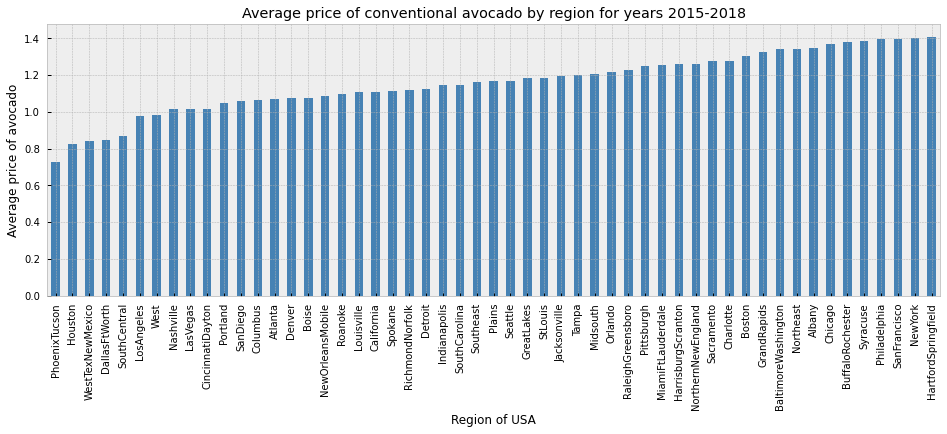

In [294]:
df = av_df_nototals[av_df_nototals.type == 'conventional'].groupby(['region'])['avg_price'].agg('mean').sort_values(ascending = True)

fig, ax = plt.subplots(figsize = (16, 5))
ax = df.plot(kind = 'bar', fontsize = 10, color = 'steelblue')

plt.xlabel('Region of USA')
plt.ylabel('Average price of avocado')
plt.title('Average price of conventional avocado by region for years 2015-2018')

plt.show()

## 5. US totals analyse

In [295]:
# Import cleaned file
av_df = pd.read_csv('avocado_cleaned.csv', parse_dates=True, index_col = [0])
total_us = av_df[av_df['region'] == 'TotalUS']
total_us = total_us.drop(columns = ['region'])
total_us.head(2)

,year,month,type,avg_price,price_category,total_sold,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags
date,,,,,,,,,,,,,
2015-12-27,2015,December,conventional,0.95,Low,27297984,9626902,10197890,1184340,6288852,4850404,1252626,185822
2015-12-20,2015,December,conventional,0.98,Low,25083647,8710021,9329862,1201020,5842744,4618390,1025049,199305


In [296]:
# Filter only totals for US and organic avocado
us_org = total_us[total_us['type'] == 'organic'].sort_values(by = ['date'])

# Filter only totals for US and conventional avocado
us_conv = total_us[total_us['type'] == 'conventional'].sort_values(by = ['date'])

us_org.head(2)

,year,month,type,avg_price,price_category,total_sold,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags
date,,,,,,,,,,,,,
2015-01-04,2015,January,organic,1.46,Medium,612910,233286,216611,4371,158642,115069,43573,0
2015-01-11,2015,January,organic,1.42,Medium,669529,270967,260972,3830,133760,106844,26916,0


### 5.1. Total volume and average price trends in US

In [297]:
# Function to simplify code while plotting timeseries

def plot_timeseries(axes, x, y, color, xlabel, ylabel, fontsize):
  axes.plot(x, y, color=color)
  axes.set_xlabel(xlabel, fontsize = fontsize)
  axes.set_ylabel(ylabel, color=color, fontsize = fontsize)
  axes.tick_params('y', colors=color)

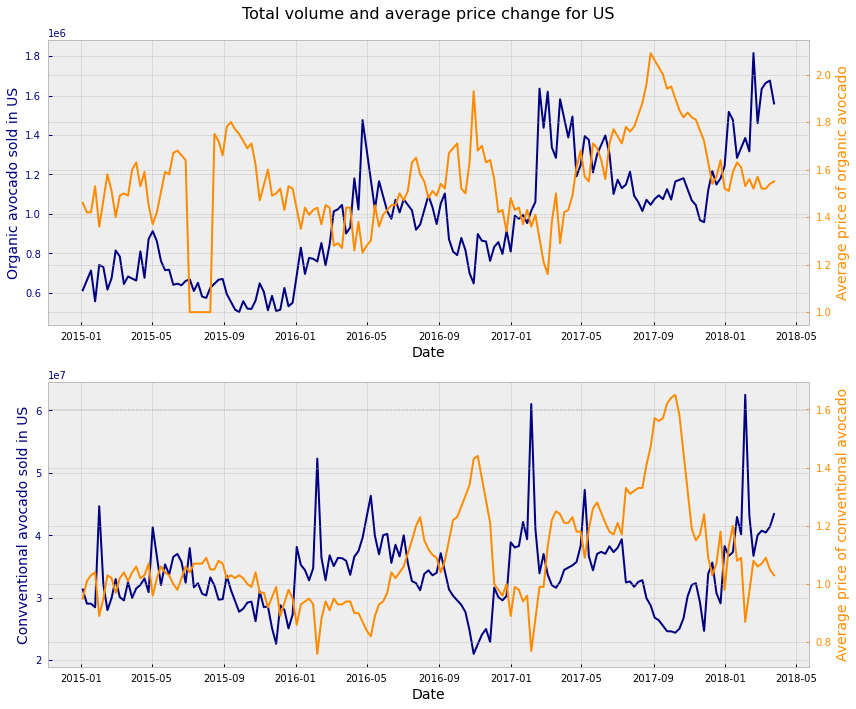

In [298]:
### ORGANIC AVOCADO PRICE AND VOLUME CHANGE
plt.style.use('bmh')

fig, ax = plt.subplots(2,1, figsize = (12,10))

# Plot total-sold time-series in blue
plot_timeseries(ax[0], us_org.index, us_org['total_sold'], 'navy', 'Date', 'Organic avocado sold in US', 14)

# Create a twin Axes object that shares the x-axis
ax2 = ax[0].twinx()
# Plot the average price in red
plot_timeseries(ax2, us_org.index, us_org['avg_price'], 'darkorange', 'Date', 'Average price of organic avocado', 14)

fig.suptitle('Total volume and average price change for US', fontsize=16)
# plt.title('Total volume and average price change for US')
plt.xticks(rotation = 90, fontsize = 14)

### CONVENTIONAL AVOCADO PRICE AND VOLUME CHANGE
# Plot TOTALS time-series in blue
plot_timeseries(ax[1], us_conv.index, us_conv['total_sold'], 'navy', 'Date', 'Convventional avocado sold in US', 14)

# Create a twin Axes object that shares the x-axis
ax2 = ax[1].twinx()

# Plot the average price in red
plot_timeseries(ax2, us_conv.index, us_conv['avg_price'], 'darkorange', 'Date', 'Average price of conventional avocado', 14)

fig.suptitle('Total volume and average price change for US', fontsize=16)
plt.xticks(rotation = 90, fontsize = 14)

plt.tight_layout()

plt.savefig(r'files/Total_volume_avg_price_trends.jpg')
plt.show()

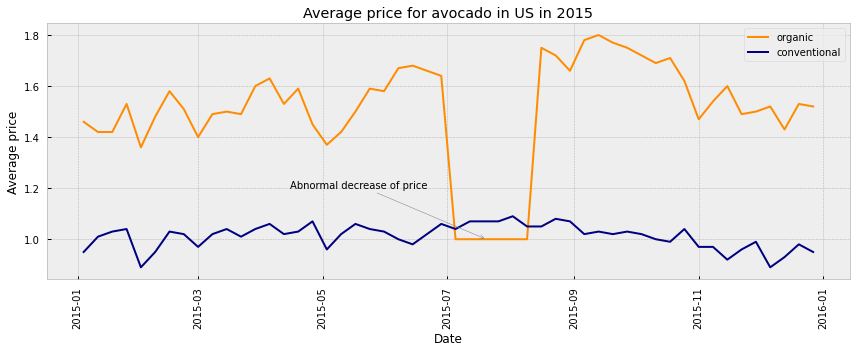

In [299]:
# Let's discover the price gap in 2015

org_2015 = us_org['2015']
conv_2015 = us_conv['2015']

fig, ax = plt.subplots(figsize=(12,5))

plt.plot(org_2015.index, org_2015['avg_price'], color = 'darkorange', label = 'organic')
plt.plot(conv_2015.index, conv_2015['avg_price'], color = 'navy', label = 'conventional')

ax.annotate('Abnormal decrease of price',
            xy = (pd.Timestamp('2015-07-20'), 1),
            xytext = (pd.Timestamp('2015-04-15'), 1.2),
            arrowprops = {'arrowstyle':'->', 'color':'grey'})

plt.xticks(rotation = 90)
plt.legend()

plt.xlabel('Date')
plt.ylabel('Average price')
plt.title('Average price for avocado in US in 2015')

plt.tight_layout()
plt.savefig(r'files/avg_price_gap_US_2015.jpg')
plt.show()
# It seems like there is a mistake in data as it's not possible that in whole US all organic avocado prices has been dropping down to 1$ (less than price for conventional avocado in this period) and than rised instantly. Therefore we should rewrite data for avg_price for dates 05-07-2015 till 09-08-2015

In [300]:
# Check where is the gap in price
org_price_gap = us_org[us_org['avg_price'] <= 1]
org_price_gap
# Problem is from July till August 2015

,year,month,type,avg_price,price_category,total_sold,small_av,large_av,xlarge_av,total_bags,small_bags,large_bags,xlarge_bags
date,,,,,,,,,,,,,
2015-07-05,2015,July,organic,1.0,Low,668233,205076,304597,6251,152309,88261,64048,0
2015-07-12,2015,July,organic,1.0,Low,608845,178873,267353,5093,157526,80221,77305,0
2015-07-19,2015,July,organic,1.0,Low,650389,159754,317728,4758,168149,81667,86482,0
2015-07-26,2015,July,organic,1.0,Low,580826,169942,266249,4391,140244,71808,68436,0
2015-08-02,2015,August,organic,1.0,Low,573873,164128,263359,5115,141271,93120,48151,0
2015-08-09,2015,August,organic,1.0,Low,625259,170186,269330,6905,178838,126059,52779,0


In [301]:
# Let's find values of average price for dates before and after gap to calculate mean value
avg_price_without_gap = us_org[(us_org.index > '2015-06-21') & (us_org.index < '2015-08-23') & (us_org.avg_price > 1.00)].mean()
avg_price_mean = avg_price_without_gap.avg_price
print("Average price of the nearest correct period is:", avg_price_mean)

Average price of the nearest correct period is: 1.6949999999999998


In [302]:
us_org.loc[us_org.avg_price == 1.00, 'avg_price'] = avg_price_mean
us_org.loc[us_org.price_category == 'Low', 'price_category'] = 'Medium'

#replace in total_us dataframe
total_us.loc[(total_us['type'] == 'organic') & (total_us.avg_price == 1.00), 'avg_price'] = avg_price_mean
total_us.loc[(total_us['type'] == 'organic') & (total_us.avg_price == avg_price_mean) & (total_us.price_category == 'Low'), 'price_category'] = 'Medium'
total_us = total_us.reset_index()

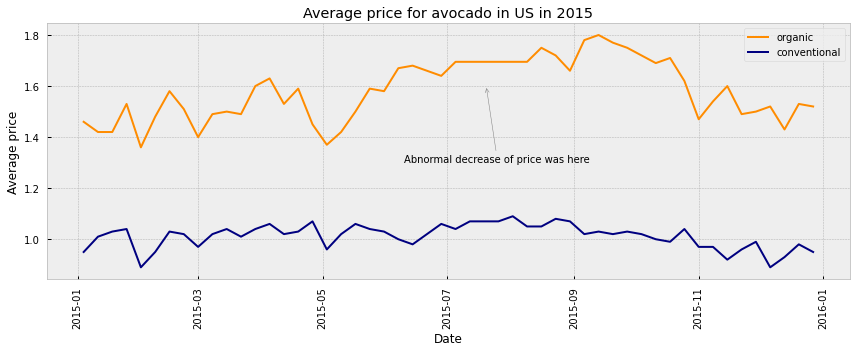

In [303]:
# Let's check chart after cleaning data

org_2015 = us_org['2015']
conv_2015 = us_conv['2015']

fig, ax = plt.subplots(figsize=(12,5))

plt.plot(org_2015.index, org_2015['avg_price'], color = 'darkorange', label = 'organic')
plt.plot(conv_2015.index, conv_2015['avg_price'], color = 'navy', label = 'conventional')

ax.annotate('Abnormal decrease of price was here',
            xy = (pd.Timestamp('2015-07-20'), 1.6),
            xytext = (pd.Timestamp('2015-06-10'), 1.3),
            arrowprops = {'arrowstyle':'->', 'color':'grey'})

plt.xticks(rotation = 90)
plt.legend()

plt.xlabel('Date')
plt.ylabel('Average price')
plt.title('Average price for avocado in US in 2015')
plt.tight_layout()

plt.savefig(r'files/avg_price_withoutgap_US_2015.jpg')
plt.show()

In [304]:
# Melt table of totals of avocado in US for further analyses
columns_tomelt = ['small_av',	'large_av',	'xlarge_av']

totals_us_melt = pd.melt(total_us, 
            id_vars=['date', 'year', 'month', 'type', 'avg_price'], 
            value_vars=columns_tomelt,
            var_name='avocado_size', 
            value_name='number_sold').sort_values(by=['date', 'avocado_size'])

totals_us_melt.reset_index(drop = True).head(8)

,date,year,month,type,avg_price,avocado_size,number_sold
0,2015-01-04,2015,January,conventional,0.95,large_av,13624083
1,2015-01-04,2015,January,organic,1.46,large_av,216611
2,2015-01-04,2015,January,conventional,0.95,small_av,12357162
3,2015-01-04,2015,January,organic,1.46,small_av,233286
4,2015-01-04,2015,January,conventional,0.95,xlarge_av,844093
5,2015-01-04,2015,January,organic,1.46,xlarge_av,4371
6,2015-01-11,2015,January,conventional,1.01,large_av,12134773
7,2015-01-11,2015,January,organic,1.42,large_av,260972


### 5.2. Number of avocado sold timeline distribution by month

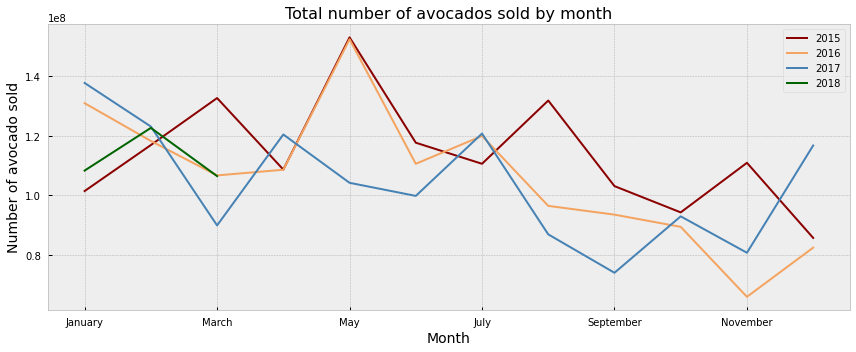

In [305]:
# # Get the total number of avocados sold on each date
fig, ax = plt.subplots(figsize = (12, 5))

sold_dict = {2015 : 'darkred', 2016 : 'sandybrown', 2017 : 'steelblue', 2018 : 'darkgreen'}
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for year, c in sold_dict.items():
    av_sold = totals_us_melt[totals_us_melt['year'] == year].groupby('month')['number_sold'].sum()
    av_sold = av_sold.reindex(months_order, axis=0)
    av_sold.plot(kind = 'line', color = c, label = year)

plt.xlabel('Month', fontsize = 14)
plt.ylabel('Number of avocado sold', fontsize = 14)
plt.title('Total number of avocados sold by month', fontsize = 16)
plt.legend()

plt.tight_layout()

plt.savefig(r'files/avocado_sold_dictrib.jpg')
plt.show()

# This chart shows the overall trend of the total number of avocado sold during 2015-2018. We can observve that the peak of avocado sold is in the month of May

### 5.3. Average price analyse

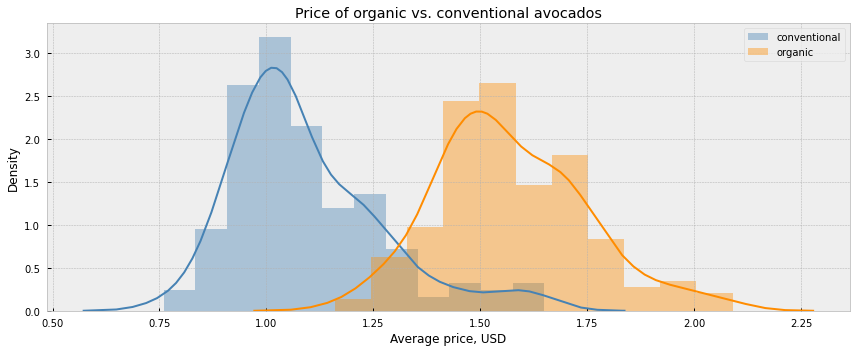

In [306]:
fig, ax = plt.subplots(figsize = (12, 5))

x = sns.distplot(us_conv['avg_price'], color = 'steelblue', label = 'conventional')
x = sns.distplot(us_org['avg_price'], color = 'darkorange', label = 'organic')

plt.title('Price of organic vs. conventional avocados')
plt.xlabel('Average price, USD')
plt.legend()
plt.tight_layout()

plt.savefig(r'files/price_distribution.jpg')
plt.show()

In [307]:
totals_us_melt.head()

,date,year,month,type,avg_price,avocado_size,number_sold
389,2015-01-04,2015,January,conventional,0.95,large_av,13624083
558,2015-01-04,2015,January,organic,1.46,large_av,216611
51,2015-01-04,2015,January,conventional,0.95,small_av,12357162
220,2015-01-04,2015,January,organic,1.46,small_av,233286
727,2015-01-04,2015,January,conventional,0.95,xlarge_av,844093


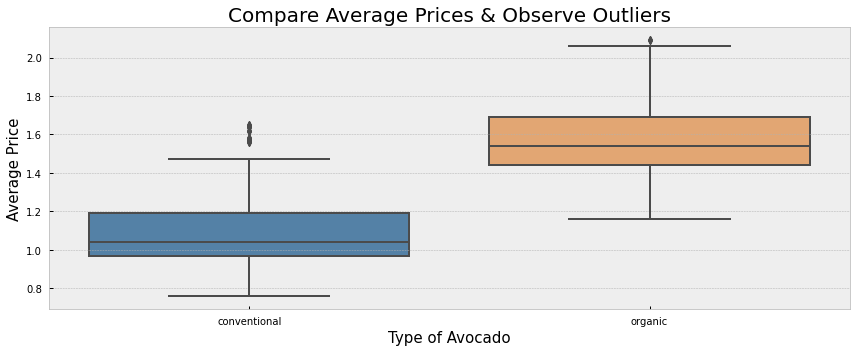

In [308]:
# ### Compare Average Prices & Observe Outliers

fig,ax = plt.subplots(figsize = (12,5))
sns.boxplot(x="type", 
            y="avg_price",
            data=totals_us_melt,
            palette=['steelblue', 'sandybrown']);
plt.title("Compare Average Prices & Observe Outliers",fontsize = 20)
plt.xlabel('Type of Avocado',fontsize = 15)
plt.ylabel('Average Price',fontsize = 15)
plt.tight_layout()

plt.savefig(r'files/price_outliers.jpg')
plt.show()

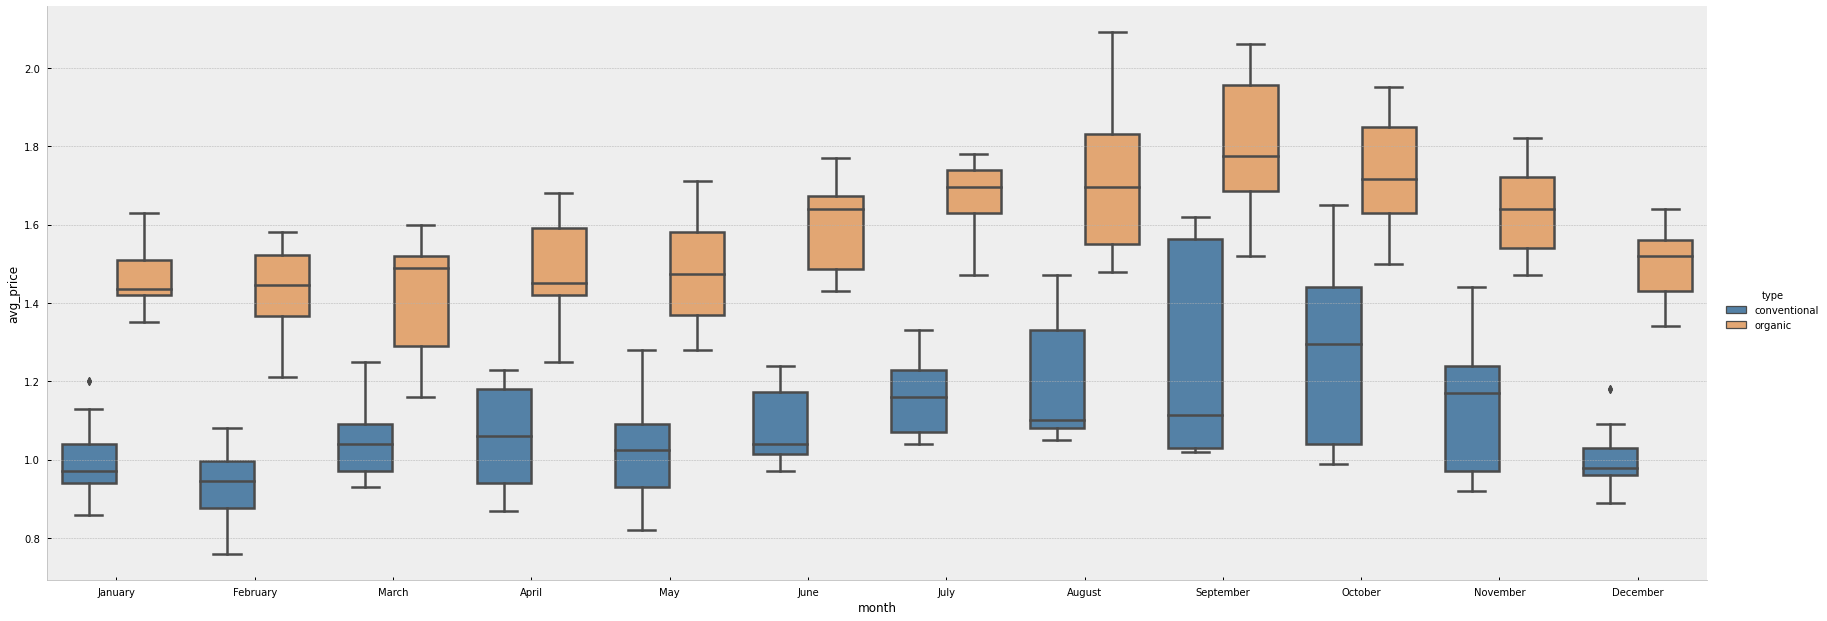

In [309]:
#Average price on timeline
ax = sns.catplot(x="month", y="avg_price", 
                hue="type", 
                kind="box",
                data=totals_us_melt, 
                height=8.5, linewidth=2.5, aspect=2.8,
                palette=['steelblue', 'sandybrown'])

plt.savefig(r'files/avg_price_distrib.jpg')
plt.show()

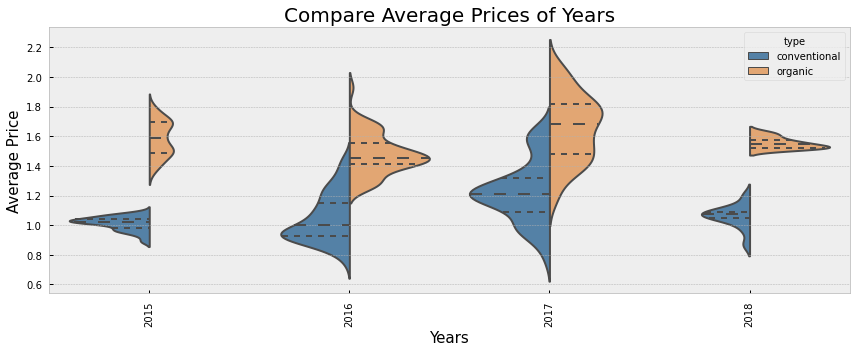

In [310]:
fig,ax = plt.subplots(figsize = (12,5))
sns.violinplot(x="year", 
               y="avg_price", 
               hue="type", 
               data=totals_us_melt,
               split=True, 
               inner="quart",
               palette=['steelblue', 'sandybrown'])

plt.xticks(rotation=90)
plt.title("Compare Average Prices of Years",fontsize = 20)
plt.xlabel('Years',fontsize = 15)
plt.ylabel('Average Price',fontsize = 15)
plt.tight_layout()

plt.savefig(r'files/avg_price_years.jpg')
plt.show()

In [311]:
# General analyse of price
total_us.groupby('type')['avg_price'].agg(['min', 'max', np.mean, np.median])

,min,max,mean,median
type,,,,
conventional,0.76,1.65,1.092012,1.04
organic,1.16,2.09,1.570710,1.54


### 5.4. Forecast

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


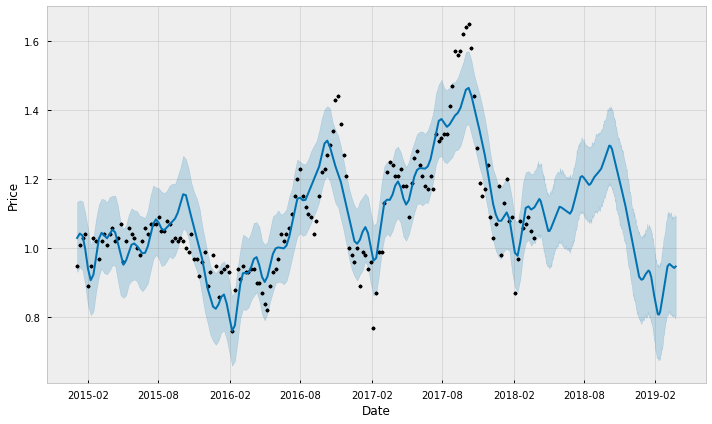

In [312]:
# Conventional avocado price forecasting
# Let's extract from dataframe only those fields we need for forecasting

us_conv_prophet = totals_us_melt[totals_us_melt.type == 'conventional'][['date', 'avg_price']]
us_conv_prophet=us_conv_prophet.rename(columns={'date':'ds','avg_price':'y'})

m=Prophet()
m.fit(us_conv_prophet)
future=m.make_future_dataframe(periods=365)
forecast=m.predict(future)

figure1=m.plot(forecast,xlabel='Date',ylabel='Price')
plt.tight_layout()

plt.savefig(r'files/forecast_price.jpg')

# So we can see from the graph that we had price for Avacado from Jan-2015 to Mar-2018.With the Prophet algorithm we are able to forecast the prices for the next years.We can see that the prediction is that the prices will go down.

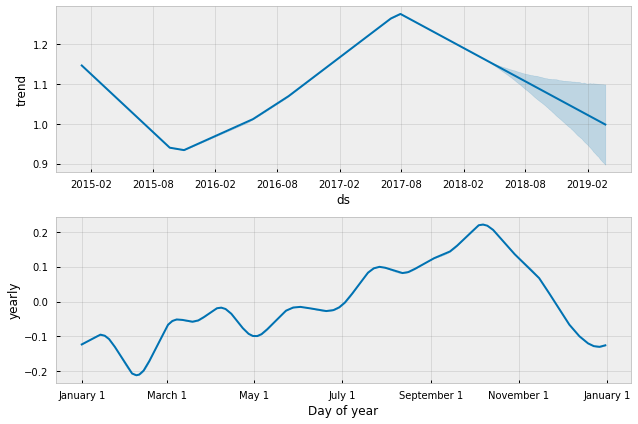

In [313]:
figure=m.plot_components(forecast)

# 1.The first graph shows the overall trend of the price in the data set and for the future forecast for one year.
# 2.The second graph show the seasonality of the price in a year,We can see that the price of Avacados Peak in the month of October

### 5.5.Avocado by size and by type analyse

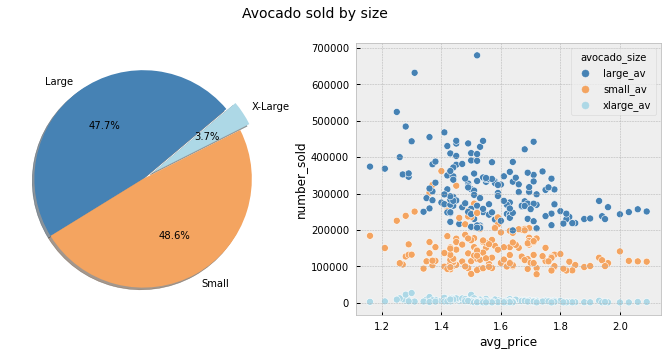

In [314]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

av_sold_by_size = totals_us_melt.groupby('avocado_size')['number_sold'].sum()
av_sold_by_size = av_sold_by_size.rename(index = {'small_av' : 'Small', 'large_av' : 'Large', 'xlarge_av' : 'X-Large'})
colors = ('steelblue', 'sandybrown', 'lightblue')

ax[0].pie(av_sold_by_size, 
        labels = av_sold_by_size.index, 
        autopct='%1.1f%%', 
        shadow=True, 
        colors = colors,
        explode=(0, 0, 0.1),
        startangle=40)

org = totals_us_melt[totals_us_melt['type'] == 'organic']
ax[1] = sns.scatterplot(x = 'avg_price', 
                        y = 'number_sold', 
                        data = org, 
                        hue = 'avocado_size',
                        palette = colors)

plt.suptitle('Avocado sold by size', fontsize = 14)

plt.savefig(r'files/av_by_size.jpg')
plt.show()

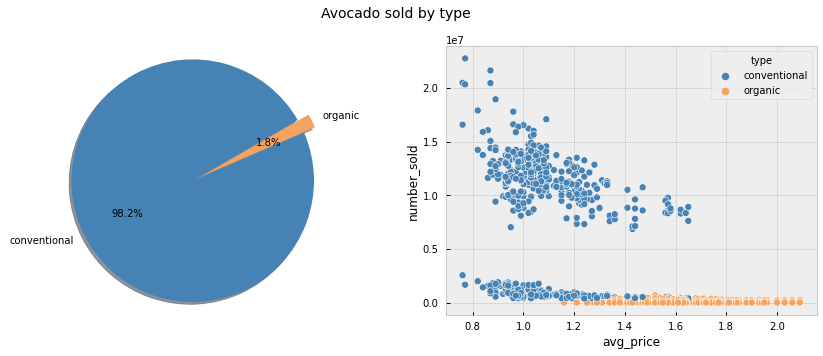

In [315]:
# Scatter plot of nb_sold vs avg_price with title
fig, ax = plt.subplots(1,2, figsize = (12, 5))

av_type = totals_us_melt.groupby('type')['number_sold'].sum()
colors = ['steelblue', 'sandybrown']

ax[0].pie(av_type, 
        labels = av_type.index, 
        autopct='%1.1f%%', 
        shadow=True, 
        colors = colors,
        explode=(0, 0.1),
        startangle=30)
ax[0].axis('equal')  

ax[1] = sns.scatterplot(x= 'avg_price', 
                y = 'number_sold', 
                hue = 'type', 
                data = totals_us_melt,
                palette = colors)

plt.suptitle('Avocado sold by type', fontsize = 14)
plt.tight_layout()

plt.savefig(r'files/av_by_type.jpg')
plt.show()